In [10]:
import torch
import numpy as np
from sklearn.preprocessing import StandardScaler




import xlrd
import pandas as pd

book = xlrd.open_workbook('dataset for standardisation.xlsx')
sheet = book.sheet_by_name('Sheet1')
data_unreplicated = [[sheet.cell_value(r, c)
         for c in range(1,9)] for r in range(2,74)]
scaler = StandardScaler()
scaler.fit(data_unreplicated)


book = xlrd.open_workbook('prepareddatakfold.xlsx')
sheet = book.sheet_by_name('Sheet1')
replicated_data = [[sheet.cell_value(r, c)
         for c in range(0,8)] for r in range(0,7200)]

def create_inout_sequences(input_data, tw):
    training_seq = []
    label_seq = []
    L = len(input_data)
    for i in range(0,L,tw):
        train_seq = input_data[i:i+tw,0:5]
        train_label = input_data[i:i+tw,5:8]
        training_seq.append(train_seq)
        label_seq.append(train_label)
    return training_seq,label_seq

standardised_data = scaler.transform(replicated_data)
x = torch.tensor(standardised_data)
z, t = create_inout_sequences(x, 12)
training_seq = torch.stack(z)
label_seq = torch.stack(t)
batch_size = 8
train = torch.utils.data.TensorDataset(training_seq,label_seq)
train_loader = torch.utils.data.DataLoader(dataset=train,
                                           batch_size=batch_size, 
                                           shuffle=False)






In [11]:
import torch.nn as nn
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # Building your RNN
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='tanh')

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # One time step
        # We need to detach the hidden state to prevent exploding/vanishing gradients
        # This is part of truncated backpropagation through time (BPTT)
        out, hn = self.rnn(x, h0.detach())

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out) 
        # out.size() --> 100, 10
        return out

In [12]:
import torch
input_dim = 5
hidden_dim = 15
layer_dim = 1 
output_dim = 3

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)
loss_fn = torch.nn.MSELoss(reduction='sum')

In [13]:
from tqdm import tqdm
from torch.autograd import Variable
model.train()
learning_rate = 0.005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs = 100

for epoch in range (epochs+1):
    for step, (x, y) in enumerate(train_loader):        # gives batch data
        b_x = Variable(x.view(-1, 12, 5))  
        b_y = Variable(y.view(-1, 12, 3))
    # Forward pass
        optimizer.zero_grad()
        y_pred = model(b_x.float())
    # Compute and print loss.
        loss = loss_fn(y_pred, b_y.float())
       
        loss.backward()
        optimizer.step()
        
    print(epoch, loss.item())



print(b_y)    
print(y_pred)


0 0.6882615089416504
1 0.4536834955215454
2 0.3902484178543091
3 0.3414234220981598
4 0.39465928077697754
5 0.3121442198753357
6 0.28895658254623413
7 0.2739664614200592
8 0.2680918276309967
9 0.25240665674209595
10 0.24968621134757996
11 0.2303585410118103
12 0.21627885103225708
13 0.19917286932468414
14 0.2006448656320572
15 0.21158774197101593
16 0.21647116541862488
17 0.1750180572271347
18 0.1600225567817688
19 0.15718235075473785
20 0.13387000560760498
21 0.11645349115133286
22 0.11286227405071259
23 0.10298751294612885
24 0.09449956566095352
25 0.08705729991197586
26 0.08649566024541855
27 0.0832461267709732
28 0.07929510623216629
29 0.08230949193239212
30 0.0798308327794075
31 0.07834640145301819
32 0.07926038652658463
33 0.08183237910270691
34 0.07712560892105103
35 0.07569199055433273
36 0.07425455003976822
37 0.07277458906173706
38 0.0713861882686615
39 0.07283022254705429
40 0.07489768415689468
41 0.07595957815647125
42 0.07467753440141678
43 0.07180285453796387
44 0.0674674

         [-1.6890, -0.4177, -2.7198]]], grad_fn=<AddBackward0>)


In [7]:
torch.save(model.state_dict(), ("C:/Users/Gabriel/Documents/Python/RNN1.pt"))                
                                

In [8]:
import xlrd
import numpy as np
from sklearn.preprocessing import StandardScaler
model.load_state_dict(torch.load("C:/Users/Gabriel/Documents/Python/RNN1.pt"))
model.eval()
book = xlrd.open_workbook('dataset for standardisation.xlsx')
sheet = book.sheet_by_name('Sheet1')
data4 = [[sheet.cell_value(r, c)
         for c in range(1,6)] for r in range(2,74)]
data5 = [[sheet.cell_value(r, c)
         for c in range(1,4)] for r in range(2,74)]
scaler = StandardScaler()
scaler2 = StandardScaler()

In [4]:
book = xlrd.open_workbook('Experimental Data edited.xlsx')
sheet = book.sheet_by_name('Sheet2')
points_given=1
data = [[sheet.cell_value(r, c)
         for c in range(1,6)] for r in range(114,114+points_given)]
data3 = [[sheet.cell_value(r, c)
         for c in range(1,4)] for r in range(115,127)]
data2 = [[sheet.cell_value(r, c)
         for c in range(1,6)] for r in range(114,126)]
actual_results = torch.tensor(data3)

scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit(data4)
scaler2.fit(data5)
standardised_data = scaler.transform(data)
standardised_data_all = scaler.transform(data2)
test_data = torch.tensor(standardised_data)
test_data_all = torch.tensor(standardised_data_all)
sequenced_test_data_all = test_data_all.view(1,12,5)
sequenced_test_data = test_data.view(1,points_given,5)

for i in range (12-points_given):
    with torch.no_grad():
         data_pred = model(sequenced_test_data.float())
    predictions = np.array(data_pred)
    tensor_predictions= torch.tensor(predictions)

    prediction_added = torch.cat((sequenced_test_data.float()[:,:,0:3],
                              tensor_predictions[:,(points_given-1)+
                                                 i:points_given+i,:]),1)
    
    sequenced_test_data = torch.cat((prediction_added,
                               sequenced_test_data_all.float()
                                     [:,0:(points_given+1)+i,3:5]),2)
 
with torch.no_grad():
     data_pred = model(sequenced_test_data.float())
predictions = np.array(data_pred)
descaled_predictions = scaler2.inverse_transform(predictions)
usable_predictions = torch.tensor(descaled_predictions)
print(usable_predictions)
print(actual_results)
x_plot = usable_predictions.view (12,3)



tensor([[[2.7514e-01, 1.1314e+03, 6.0964e-01],
         [4.4311e-01, 8.9294e+02, 1.1045e+00],
         [6.6486e-01, 1.0091e+03, 1.5973e+00],
         [9.0662e-01, 9.5816e+02, 2.0789e+00],
         [1.1384e+00, 7.7225e+02, 2.5790e+00],
         [1.3762e+00, 9.3480e+02, 3.0841e+00],
         [1.6087e+00, 1.1036e+03, 3.4644e+00],
         [1.8572e+00, 1.0504e+03, 3.7922e+00],
         [2.1309e+00, 1.0187e+03, 4.1312e+00],
         [2.3363e+00, 1.0901e+03, 4.3876e+00],
         [2.4830e+00, 1.3530e+03, 4.6124e+00],
         [2.5668e+00, 1.5797e+03, 4.7471e+00]]])
tensor([[2.6670e-01, 7.2290e+02, 4.6200e-01],
        [4.5930e-01, 5.7480e+02, 7.7700e-01],
        [6.3910e-01, 5.1690e+02, 1.2180e+00],
        [8.7080e-01, 4.0420e+02, 1.8060e+00],
        [1.1327e+00, 3.3580e+02, 2.3520e+00],
        [1.3546e+00, 5.3840e+02, 2.7720e+00],
        [1.5643e+00, 8.1020e+02, 3.3180e+00],
        [1.7803e+00, 1.0283e+03, 3.9690e+00],
        [1.9670e+00, 1.2304e+03, 4.3680e+00],
        [2.1856e+00,

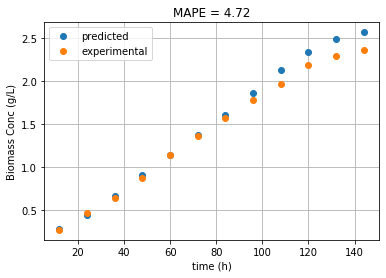

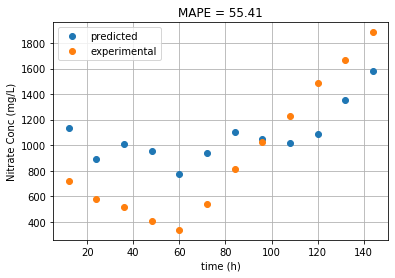

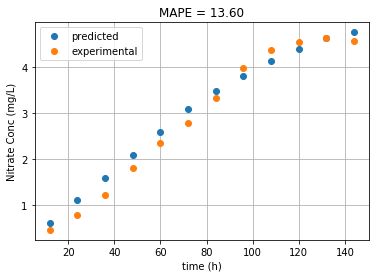

In [6]:
def MAPE(y_true, y_pred):
    MAPE_Total=0
    for i in range(len(y_pred)):
        MAPE = torch.abs((y_true[i:1+i,:]-y_pred[i:1+i,:])/y_true[i:1+i,:])
        MAPE_Total += (MAPE/len(y_pred))*100
    return MAPE_Total

import numpy as np
a = np.linspace(12,144,12)
v = torch.tensor(data3)
import matplotlib.pyplot as plt 
y1 = x_plot[:, 0:1] 
x1 = a
plt.plot(x1, y1,'o' ,label = "predicted") 

y2 = v[:, 0:1] 
x2 = a
plt.plot(x2, y2, 'o',label = "experimental") 
plt.xlabel('time (h)')
plt.ylabel('Biomass Conc (g/L)')
loss = MAPE(v[:, 0:1],x_plot[:, 0:1])
plt.title(('MAPE = {:.2f}'.format(loss.item())))
plt.grid(b=True,which='major', axis='both')
plt.legend()
plt.show() 


y1 = x_plot[:, 1:2] 
x1 = a
plt.plot(x1, y1,'o',label = "predicted") 

y2 = v[:, 1:2] 
x2 = a
plt.plot(x2, y2,'o',label = "experimental") 
plt.xlabel('time (h)')
plt.ylabel('Nitrate Conc (mg/L)')
loss = MAPE(v[:, 1:2],x_plot[:, 1:2])
plt.title(('MAPE = {:.2f}'.format(loss.item())))
plt.grid(b=True,which='major', axis='both')
plt.legend()
plt.show() 

y1 = x_plot[:, 2:3] 
x1 = a
plt.plot(x1, y1,'o',label = "predicted") 

y2 = v[:, 2:3] 
x2 = a
plt.plot(x2, y2,'o',label = "experimental") 
plt.xlabel('time (h)')
plt.ylabel('Lutein Conc (mg/L)')
loss = MAPE(v[:, 2:3],x_plot[:, 2:3])
plt.title(('MAPE = {:.2f}'.format(loss.item())))
plt.grid(b=True,which='major', axis='both')
plt.legend()
plt.show() 



In [27]:
import pandas as pd
b=np.array(v)
c=np.array(x_plot)
book = xlrd.open_workbook('tested data.xlsx')
sheet = book.sheet_by_name('Sheet1')
writer = pd.ExcelWriter('tested data.xlsx', engine='xlsxwriter')
df1 = pd.DataFrame(b)
df1.to_excel(writer, header=True, index=True)
df2 = pd.DataFrame(c)
df2.to_excel(writer, startrow=13, header=True, index=True)
writer.save()